In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from source.DataFrameSelector import DataFrameSelector

DATA_PATH = os.path.join("..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

In [2]:
def import_data():
    e_data = load_csv("energy_dataset.csv")
    w_data = load_csv("weather_features.csv")
    # weather_id ist abgeleitet von clouds_all
    # weather_id ist die numerische klassifikation von weather_description
    # weather_main ist eine ungenaue darstellung von weather_description
    # weather_icon ist ?
    # in den meisten fällen ist temp = temp_min = temp_max
    w_data = w_data.drop(columns=["weather_id", "weather_icon", "weather_main", "temp_min", "temp_max"])
    return w_data.join(other=e_data[["time", "price"]].set_index("time"), on="time")

data = import_data()

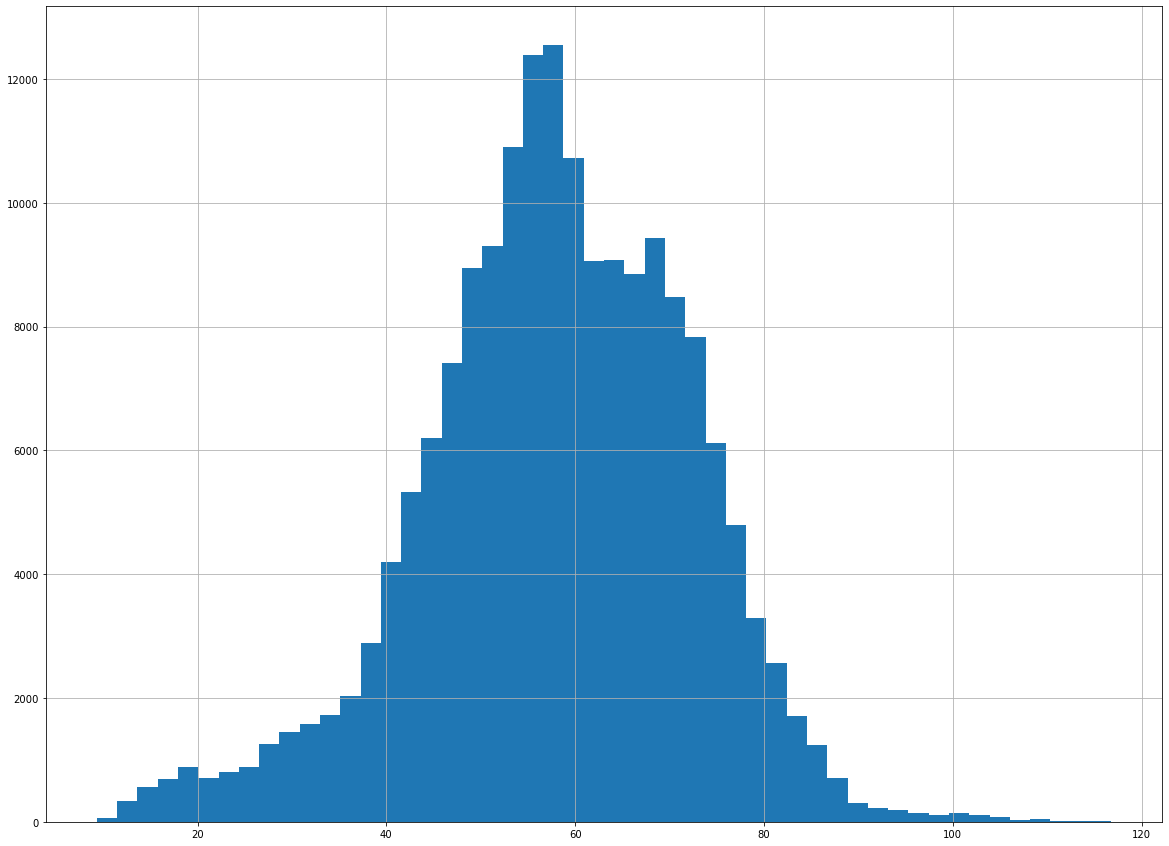

In [30]:
data["price"].hist(bins=50, figsize=(20, 15))

In [3]:
label = "price"
X_train = X_test = y_train = y_test = None
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["city_name"]):
    X_train = data.loc[train_index]
    y_train = X_train[label]
    X_train = X_train.drop(columns=[label])
    X_test = data.loc[test_index]
    y_test = X_test[label]
    X_test = X_test.drop(columns=[label])
    
X_test["city_name"].value_counts() / len(X_test)

Madrid        0.203307
Bilbao        0.201513
Seville       0.199327
 Barcelona    0.198851
Valencia      0.197001
Name: city_name, dtype: float64

In [17]:
#encoder = OneHotEncoder()
#oneHotClouds = encoder.fit_transform(tmp["weather_id"].to_numpy().reshape(-1,1))
cat_attribs = ["city_name"]
num_attribs = ['rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']
poly_attribs = ['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg']
degree = 2

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribs)),
    ("std_scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attribs)),
    ("cat_encoder", OneHotEncoder(sparse=False))
])
poly_pipeline = Pipeline([
    ("selector", DataFrameSelector(poly_attribs)),
    ("poly_features", PolynomialFeatures(degree=degree)),
    ("std_scaler", StandardScaler())
])
pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("poly_pipeline", poly_pipeline),
    #("cat_pipeline", cat_pipeline)
])
pipeline.fit(X_train)
X_prepared = pipeline.transform(X_train)

In [18]:
def foo(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return rmse_train, rmse_test

#svm_reg = SVR(kernel="poly", degree=2, C=1, epsilon=0.1)
lin_reg = RandomForestRegressor()
print(foo(lin_reg, X_prepared, y_train, pipeline.transform(X_test), y_test))

# lineare_regression (13.977081227562822, 13.945052725340519)
# poly_regression 
#   degree 2    (13.853527042680058, 13.828147812150833)    ohne pressure/ humidity
#   degree 2    (13.808968948355282, 13.793752486988796)    mit pressure / humidity
#   degree 3    (13.714074208559285, 13.683145331334556)    nur ['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg'] als poly
#   degree 3    overfit
# Random Forest
# degree 3 von ['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg'] (4.6769143747021, 12.257459179998438)
# degree 2 von s.o. (4.647315055937049, 12.1596083705406)

(4.646843424167619, 12.163875162446075)


In [31]:
print(lin_reg.coef_)
#print(X_prepared[0])
#print(X_train.iloc[0])

[ 5.25961984e+09  4.54968770e+07 -2.39049790e+08 -8.23057839e+08
  0.00000000e+00 -1.09687986e+08  2.15635083e+10 -8.07019075e+08
 -4.41791197e+08  4.33342784e+07 -5.12143684e+06 -9.00916514e+07
  8.78944839e+07  8.68874487e+07  1.79910283e+08]
